In [ ]:
import os

train_dir = '/kaggle/input/ucf-crime-dataset/Train'
class_names = []


for item in os.listdir(train_dir):
    item_path = os.path.join(train_dir, item)
    if os.path.isdir(item_path):
        class_names.append(item)

print("Classes found:", class_names)
print("Total:", len(class_names))


In [ ]:
from PIL import Image
img = Image.open("/kaggle/input/ucf-crime-dataset/Train/Arrest/Arrest002_x264_0.png")
print(img.size) 

In [ ]:
ALLOWED_CLASSES = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 
                   'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 
                   'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 
                   'Vandalism']

DATA_PATH = '/kaggle/input/ucf-crime-dataset/Train'  

import os
import glob

for cls in ALLOWED_CLASSES:
    class_path = os.path.join(DATA_PATH, cls)
    if os.path.exists(class_path):
        print(f"{cls} folder found.")
        for vid in os.listdir(class_path):
            vid_path = os.path.join(class_path, vid)
            num_frames = len(glob.glob(os.path.join(vid_path, '*.png')))
            print(f"{vid}: {num_frames} frames")
    else:
        print(f"{cls} folder NOT found at {class_path}")



In [ ]:

import os
import random
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from torchvision.models import ResNet18_Weights


DATA_PATH = '/kaggle/input/ucf-crime-dataset/Train'
ALLOWED_CLASSES = ['Fighting', 'Vandalism', 'Stealing', 'NormalVideos']
SEQUENCE_LENGTH = 16
IMAGE_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 30
NUM_CLASSES = len(ALLOWED_CLASSES)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


class VideoDataset(Dataset):
    def __init__(self, root_dir, sequence_length=16, transform=None):
        self.sequence_length = sequence_length
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(ALLOWED_CLASSES)}
        self.samples = []

        for class_name in ALLOWED_CLASSES:
            class_path = os.path.join(root_dir, class_name)
            if not os.path.exists(class_path):
                continue

            video_frames = {}
            for frame_name in sorted(os.listdir(class_path)):
                if frame_name.endswith('.png') or frame_name.endswith('.jpg'):
                    video_name = "_".join(frame_name.split("_")[:2])
                    video_frames.setdefault(video_name, []).append(os.path.join(class_path, frame_name))

            for vid, frames in video_frames.items():
                frames = sorted(frames)
                if len(frames) >= sequence_length:
                    self.samples.append((frames, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        start = random.randint(0, len(frame_paths) - self.sequence_length)
        frames = []

        for i in range(start, start + self.sequence_length):
            img = Image.open(frame_paths[i]).convert('RGB')
            img = self.transform(img)
            frames.append(img)

        return torch.stack(frames), label


class CNN_LSTM(nn.Module):
    def __init__(self, hidden_dim=512, num_classes=NUM_CLASSES):
        super(CNN_LSTM, self).__init__()
        resnet = 
        models.resnet18
        (weights=None)
        state_dict = torch.load("/kaggle/input/weights/resnet18-f37072fd.pth",weights_only = True)
        resnet.load_state_dict(state_dict)

        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):  # x: [B, T, C, H, W]
        B, T, C, H, W = x.size()
        x = x.view(B * T, C, H, W)
        with torch.no_grad():
            cnn_features = self.cnn(x).squeeze()
        cnn_features = cnn_features.view(B, T, -1)
        lstm_out, _ = self.lstm(cnn_features)
        out = self.fc(lstm_out[:, -1, :])
        return out


dataset = VideoDataset(DATA_PATH, sequence_length=SEQUENCE_LENGTH, transform=transform)


all_indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)


model = CNN_LSTM().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4) 


for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0

    for sequences, labels in train_loader:
        sequences = sequences.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_accuracy = correct / len(train_dataset)

    
    model.eval()
    val_correct = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(sequences)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_accuracy = val_correct / len(val_dataset)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")


torch.save(model.state_dict(), 'cnn_lstm_ucf_final.pth')
print("✅ Model training complete and saved!")


/tmp/ipykernel_31/1749513368.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/weights/resnet18-f37072fd.pth")
/tmp/ipykernel_31/17

Test Accuracy: 0.3750


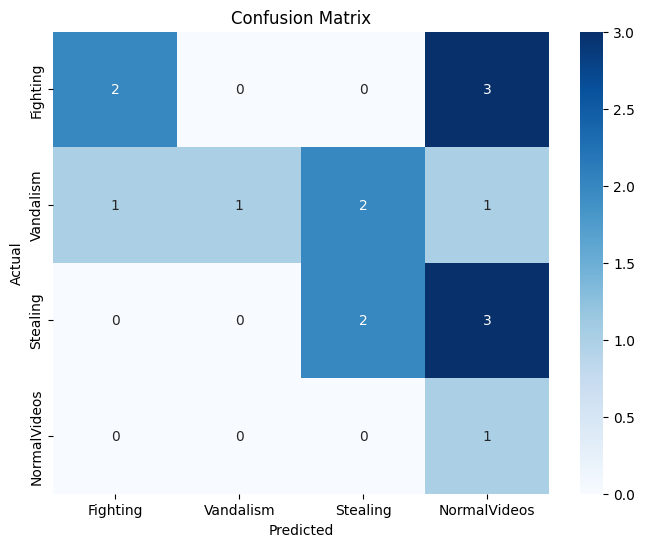

In [11]:
#Test Code
import os
import random
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ========== CONFIGURATION ==========
DATA_PATH = '/kaggle/input/ucf-crime-dataset/Test'
ALLOWED_CLASSES = ['Fighting', 'Vandalism', 'Stealing', 'NormalVideos']
SEQUENCE_LENGTH = 6
CLIPS_PER_VIDEO = 1
IMAGE_SIZE = 224
BATCH_SIZE = 4
NUM_CLASSES = len(ALLOWED_CLASSES)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== TRANSFORM ==========
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ========== TEST DATASET ==========
class TestVideoDataset(Dataset):
    def __init__(self, root_dir, sequence_length=6, clips_per_video=1, transform=None):
        self.sequence_length = sequence_length
        self.transform = transform
        self.clips_per_video = clips_per_video
        self.class_to_idx = {cls: idx for idx, cls in enumerate(ALLOWED_CLASSES)}
        self.samples = []

        for class_name in ALLOWED_CLASSES:
            class_path = os.path.join(root_dir, class_name)
            if not os.path.exists(class_path):
                continue

            video_frames = {}
            for frame_name in sorted(os.listdir(class_path)):
                if frame_name.endswith('.png') or frame_name.endswith('.jpg'):
                    video_name = "_".join(frame_name.split("_")[:2])
                    video_frames.setdefault(video_name, []).append(os.path.join(class_path, frame_name))

            for vid, frames in video_frames.items():
                frames = sorted(frames)
                if len(frames) >= sequence_length:
                    self.samples.append((frames, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        clips = []
        max_start = len(frame_paths) - self.sequence_length

        for _ in range(self.clips_per_video):
            start = random.randint(0, max_start)
            frames = []
            for i in range(start, start + self.sequence_length):
                img = Image.open(frame_paths[i]).convert('RGB')
                img = self.transform(img)
                frames.append(img)
            clips.append(torch.stack(frames))

        return torch.stack(clips), label

# ========== MODEL ==========
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_dim=512, num_classes=NUM_CLASSES):
        super(CNN_LSTM, self).__init__()
        resnet = models.resnet18(weights=None)
        state_dict = torch.load("/kaggle/input/weights/resnet18-f37072fd.pth")
        resnet.load_state_dict(state_dict)

        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):  # x: [B, N, T, C, H, W]
        B, N, T, C, H, W = x.shape
        x = x.view(B * N * T, C, H, W)
        cnn_features = self.cnn(x).squeeze(-1).squeeze(-1)  # shape: [B*N*T, 512]
        cnn_features = cnn_features.view(B * N, T, -1)      # shape: [B*N, T, 512]
        lstm_out, _ = self.lstm(cnn_features)               # shape: [B*N, T, H]
        output = self.fc(self.dropout(lstm_out[:, -1, :]))  # shape: [B*N, num_classes]
        output = output.view(B, N, -1).mean(dim=1)           # average over clips
        return output

# ========== LOAD MODEL ==========
model = CNN_LSTM().to(DEVICE)
model.load_state_dict(torch.load("/kaggle/working/cnn_lstm_ucf_final.pth"))
model.eval()

# ========== TESTING ==========
test_dataset = TestVideoDataset(DATA_PATH, SEQUENCE_LENGTH, CLIPS_PER_VIDEO, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

all_preds, all_labels = [], []

with torch.no_grad():
    for clips, labels in test_loader:
        clips = clips.to(DEVICE)  # shape: [B, N, T, C, H, W]
        labels = labels.to(DEVICE)
        outputs = model(clips)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



# ========== ACCURACY ==========
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

# ========== CONFUSION MATRIX ==========
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=ALLOWED_CLASSES, yticklabels=ALLOWED_CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()